# An implementation of a MDP Slice Sampler from (Walker 2007). 


This work is based on the code from Alvin Shi at MIT. I fixed some bugs and using it for my research

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.mixture import GMM
import scipy.stats as stats
from scipy.stats import gamma, norm, uniform
from functools import partial
from scipy.special import gamma
%matplotlib inline
def lambda_to_std(_lambda): 
    #function for converting lambdas given in the Walker paper for usage in generation of random variates
    return 1/(np.sqrt(_lambda))
    
def count_unique(val, vec): 
    #simple function to count unique occurrences 
    counter = 0
    for _val in vec:
        if val == _val:
            counter += 1
    return counter 


def movingaverage(interval, window_size): #plotting auxiliary function 
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def runningMeanFast(x, N): #plotting auxiliary function
    return np.convolve(x, np.ones((N,))/N)[(N-1):]
    
np.random.seed(1234)

First, we want to generate the test data, Gaussian Mixture Models that Walker uses. Let $$f(y) = \frac{1}{3} N(y \mid -4, 1) + \frac{1}{3} N(y \mid 0, 1) + \frac{1}{3} N(y \mid 8, 1) $$ 
We can use sci-kit learn's GMM library to simulate the draws as follows:

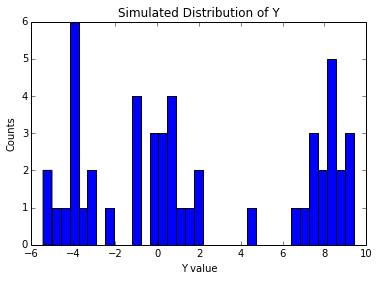

In [2]:
gmm = GMM(3, n_iter=1)
gmm.means_ = np.array([[-4], [0], [8]])
gmm.covars_ = np.array([[1], [1], [1]]) ** 2
gmm.weights_ = np.array([0.334, 0.333, 0.333])
Y = gmm.sample(50)
Y = Y.flatten()
plt.clf()
plt.hist(Y, bins= 35)
plt.title('Simulated Distribution of Y')
plt.xlabel('Y value')
plt.ylabel('Counts')

Now, we will walk through a single round of the Splice Sampling. First, we need to initalize values for our latent variables.

Let's walk through the initialization of variables for the $\theta = (\mu_j, \sigma^2)$ first. Walker describes the conditional distributions for $\mu_j$ and $\lambda_j$ as follows:

$$f(\mu_j \mid \ldots) = N\left( \frac{\xi_j \lambda_j}{m_j \lambda_j + s},  \frac{1}{m_j \lambda_j + s} \right)$$

Walker gives prior values for $\mu_j \sim N(0, 1/s)$, and $\lambda \sim Ga(\epsilon, \epsilon)$. The values for his particular example are $\epsilon = 0.5$ and $s = 0.1$. We will initalize these below. 

There is also a prior on $c$ ($\alpha$ in previous schemes), it is given as $c \sim Gamma(a = 0.1, b = 0.1)$. We will declare those as well. 

Finally, using the notation from Escobar and West (1995), which Walker references for inference of $c$, we need to initalize a latent variable $\nu$ (which is $\eta$ in their notation) to assist with inference of $c$. Escobar and West don't really reference how $\nu$ is initalized, but we know it's distributed according to $\nu \sim Beta(c+1, n)$, where $n$ is the number of observed values in $Y$, so we will just randomly initalize a value from this distribution.

I'll also initalize $c$ as 1. Again, it's possible to alternatively specify it as being drawn from $Gamma(0.1,0.1)$, that alternative is commented out.

In [3]:
epsilon = 0.5
s = 0.1
s_inv = 1/s
s_sqrt = np.sqrt(s_inv) #easier for generation with numpy.random.normal later, since we have to specify the standard deviation
a = 0.1 
b = 0.1 
c = 1
#c = np.random.gamma(0.1, 0.1)
nu = np.random.beta(c+1, len(Y))

Next we initalize our weights $w$, our cluster assiginments (and total number of clusters) $z$, our stick breaking measures $v$, and our initial $\theta = (\mu, \lambda)$. There are several ways to initalize $w$ and $k$. It's not specificed in Walker how they chose these initial values. I'll start with $k = 1$ and $w$ drawn randomly from $Beta(1, c)$. 

First stick-breaking value $v_0$ is equal to $w_0$.



In [4]:
#initalize first weights
w = []
w.append(np.random.beta(1, c))

v = []
v.append(w[0])
#initalize first mu (cluster mean)
mus = []
mus.append(np.random.normal(0, s_sqrt))

#initalize first lambda (inverse sigma^2)
lambdas = []
lambdas.append(np.random.gamma(epsilon,1/epsilon))
stds = [] #to keep track of actual sigma generated
stds.append(lambda_to_std(lambdas[0]))
z = np.zeros(len(Y)) #cluster assignments
u = np.zeros(len(Y))
active_ks = []
total_ks = []
total_cs = []

One particular problem I had is with the parameterization of $Gamma$ in the Walker paper. 

The Gamma distribution can be parameterized either with a shape parameter $k$ and a scale parameter $\theta$, or alternatively with a shape parameter $\alpha = k$ and a rate parameter $\beta = 1 / \theta$. 

In Bayesian settings (according to wikipedia), the shape and rate $(\alpha, \beta)$ parameterization is most often used. However, Escobar and West (1995) use  $(k, \theta)$, shape and scale, instead.  

For reasons that will be clear in a few minutes, I'll assume that Walker uses the $Gamma(\alpha, \beta)$ parameterization, and Escobar and West uses $Gamma(k, \theta)$. 

Note that numpy.random.gamma uses the $k, \theta$ notation, so i'll be inverting most of the 2nd parameters in Walker.

## One iteration of slice sampling

Let's do the first step of slice sampling. We first want to initalize our auxiliary variable $u$. Recall the step for generating this is given below:

For $i=1 \dots n$, pick $u_i \sim U(0,w_{k_i})$, choose $u^* = min\{u_1 \dots u_n\}$

Where $n$ is the number of observations in $Y$ 

0.00613155165067


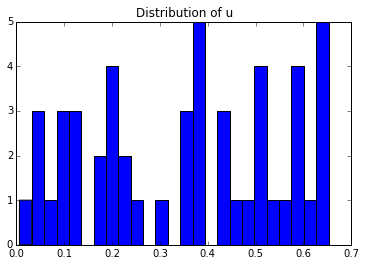

In [5]:
    u = np.zeros(len(Y))
    for idx, val in enumerate(Y):
        cluster_label = int(z[idx]) #vector z holds all the current cluster assignments indexed 0...k-1
        u[idx] = np.random.uniform(0, w[cluster_label]) #we can fetch the current w_k from the w vector, with same indexing scheme as k
    #min u 
    u_star = np.min(u)
    plt.hist(u, bins=25)
    plt.title('Distribution of u')
    print u_star

Now let's do the next step, which is: 

Create new components through stick breaking until we have $k^*$

To do this, we can re-formulate the equation:
$$\sum_{j=1}^{k^*} w_j > 1-u^*$$

We can re-arrange to derive, $\beta^*$, which is $1 - \sum_{j=1}^{k^*} w_j$. Now we see that the above condition is now:

$$u^* > \sum_{j=1}^{k^*} w_j$$
$$u^* > \beta^*$$
So while this above expression is not true, we need to generate more components $k$ until we reach $k^*$.

For each new $k$ that is generated, we can draw the corresponding $\theta = (u, \sigma^2)$ values straight from the priors specified earlier

The stick-breaking lengths corresponding to each new segment is  generated as 

$$v_{k} = Beta(1, c)$$


In [6]:
    beta_star = 1 - np.sum(w)

    while (beta_star >= u_star): #generate a new k while this condition is true
        _vk = np.random.beta(1, c)
        beta_k = _vk * beta_star
        
        #append beta_k to the weights
        w.append(beta_k)
            
        #append _vk to v
        v.append(_vk)
        
        #append new mu to mus 
        mus.append(np.random.normal(0, s_sqrt)) #draw from our prior N(0, 1/s)
        
        #append new lambda to lambda
        new_lambd = np.random.gamma(epsilon, 1/epsilon) #draw from Gamma(epsilon, epsilon)
        lambdas.append(new_lambd)

        
        #finally update beta_star
        beta_star = beta_star*(1 -_vk)

We can check that $\beta^*$ is now below $u^*$. 

Additionally, we can inspect the number of instantiated components

In [7]:
print "Beta star is", beta_star
print "u star is" , u_star
print "Number of instianted components is " , len(w)
print "sample means for each new cluster"
print mus
print "lambdas for each new cluster"
print lambdas
#convert lambdas to sigmas
sigma = [lambda_to_std(x) for x in lambdas]
print "Sigma (translated lambda)"
print sigma

Beta star is 0.0028603334611
u star is 0.00613155165067
Number of instianted components is  4
sample means for each new cluster
[0.920872203636786, 1.7915368517115182, 4.29373193634983, -2.545107706082487]
lambdas for each new cluster
[1.2862251963811038, 0.26735463409442745, 0.45232713086903725, 0.058800671435076536]
Sigma (translated lambda)
[0.88174193000543599, 1.9339985400609325, 1.4868723354578228, 4.1239069489065674]


Now that we have the optimal number of potential components $k^*$, we can start assigning our observed points in $Y$ to these clusters. 

This is given by the following equation: 

$$ p(\delta_i  = k| y_i, u_i, w, \theta) \propto  1{\{k:w_k > u^* \}}P(y_i|\theta_k)$$

It's perhaps easier to express this as:

$$ p(\delta_i  = k| y_i, u_i, w, \theta) \propto \begin{cases} N(y_{i} \mid \theta_k) & \text{if } w_k \geq u_{i} \\ 0 & \text{otherwise} \end{cases}$$

We'll use the scipy normal distribution to generate the pdf for each $Y_{i}$ for each cluster. We can then renormalize these weights and draw from this discrete distribution use scipy custom r.v. object. These assignments will form the new $z$

In [8]:
    assert len(w) == len(mus)
    assert len(w) == len(lambdas)
    
    #now we get the cluster assignments z for each observation
    for y_idx , y_val in enumerate(Y):
        z_probs = np.zeros(len(w)) #initalize placeholder for new zs
        for cluster_idx, mu in enumerate(mus):
            if w[cluster_idx] > u[y_idx]:
                z_probs[cluster_idx] = norm.pdf(y_val, loc = mu, scale = lambda_to_std(lambdas[cluster_idx]))
            else:
                z_probs[cluster_idx] = 0
        #sample cluster assignments
        norm_z_probs = z_probs / np.sum(z_probs) #normalize and feed into a discrete r.v.
        z_sampler = stats.rv_discrete(name = "z_sampler", values = (np.arange(len(z_probs)), norm_z_probs))
        z_assignment = z_sampler.rvs()
        z[y_idx] = z_assignment #grab z_assignment
        #print "%i\t%0.03f\t%0.03f\t%0.03f\t%i"%(y_idx, y_val, mu_)
    
    z_ints = [int(x) for x in z] #make z ints for easier use in future 
    print z

[ 0.  0.  0.  2.  2.  0.  1.  2.  2.  0.  0.  0.  2.  2.  0.  0.  0.  0.
  2.  0.  0.  0.  1.  0.  0.  0.  0.  2.  0.  0.  2.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


We can see how the cluster assignments turned out. We don't expect these to be great. 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


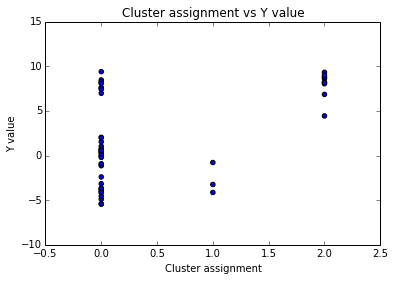

In [9]:
plt.scatter(z, Y)
plt.title('Cluster assignment vs Y value')
plt.xlabel('Cluster assignment')
plt.ylabel('Y value')

As we observe here, we only used 4 of the 12 total possible $k^*$. This is perhaps a downside of $Y$, in the sense that our "dynamic truncation" is potentially causing us to waste computational resources to sample $w_k$ and calculate $p(\delta_{i} \mid \ldots)$ for a large number of clusters that we may not necessarily care about.

Next, let's update our $\theta$. This involves updating $\mu$ and $\lambda$. We know that the updates (from Walker section 4) to be:

$$f(\mu_j \mid \ldots) = N\left( \frac{\xi_j \lambda_j}{m_j \lambda_j + s},  \frac{1}{m_j \lambda_j + s} \right)$$
Where,
$$\xi_j = \sum_{k_{i} = j} y_{i}$$
$$m_j = \sum_{k_{i} = j} 1$$

The updates for $\lambda_j$ is as follows:
$$f(\lambda_j \mid \ldots) = Gamma(\epsilon + m_j/2 , \epsilon + d_j/2)$$
where,
$$d_j = \sum_{k_{i} = j } (y_{i} - \theta_j)^2$$

I'm unsure why Walker used $\theta_j$ instead of $\mu_j$ here...as I'm unsure of how to incorporate $\theta = (\mu, \lambda)$ information. 

In [10]:
    z_ints = [int(x) for x in z] #make z ints for easier use in future 
    
    #perform necessary updates for means and lambdas for each cluster 
    new_mus = []
    new_lambdas = []
    new_z = np.zeros(len(Y))
    active_cluster = 0
    count_dict = {}
    
    for cluster_idx in range(len(w)):
        #update means
        cur_lambda = lambdas[cluster_idx]    
        eta = 0
        m = 0
        y_k = []
        for y_idx, z_val in enumerate(z_ints):
            if z_val == cluster_idx:
                m += 1
                eta += Y[y_idx]
                y_k.append(Y[y_idx])
                new_z[y_idx] = active_cluster
        
        if m == 0: #if un-utilized cluster, skip and don't add weights/means
            continue
        else:
            count_dict[active_cluster] = m
            active_cluster += 1        
            _mean = (eta * cur_lambda)/(m * cur_lambda + s)
            _variance = 1 / (m * cur_lambda + s)
            new_mu = np.random.normal(_mean, np.sqrt(_variance)) #draw new mu from N()
            #mus[cluster_idx] = new_mu
            new_mus.append(new_mu)
            #update lambda
            d = 0
            for val in y_k:
                d += (val - new_mu) ** 2 #calculate d_j
            
            _alpha = epsilon + m/2
            _beta = epsilon + d/2
            new_lambda = np.random.gamma(_alpha, 1/_beta) #draw new lambda from Gamma
            #lambdas[cluster_idx] = new_lambda
            #print "added at %i"%(cluster_idx)
            new_lambdas.append(new_lambda)
            #stds.append(lambda_to_std(new_lambda))

In [11]:
#inspect the new valeus
print new_mus
print new_lambdas
print [lambda_to_std(x) for x in new_lambdas]

[0.7266178304840947, -2.6714341745650305, 8.261895678786171]
[0.042254074667477354, 0.49656240056638856, 0.3199645899415874]
[4.8648079742598691, 1.4191002744385779, 1.7678647684766686]


Now let's update our $v_{k}$ and $w_{k}$ vectors. We know that 

$$v_k \mid c, \delta \sim Beta(1+n_k, c + \sum_{l=k+1}^{k^*} n_l)$$

and

$$w_k = v_k \prod \limits_{l=1}^{k-1}(1-v_l)$$

In [12]:
    k = active_cluster 
    vks = []
    #print count_dict
    for cluster_idx in range(k):
        n_k = count_dict[cluster_idx]
        n_j = 0
        #print range(cluster_idx + 1, k )
        for i in range(cluster_idx+1, k):
            n_j += count_dict[i]
        vks.append(np.random.beta(1 + n_k, c + n_j))
        
    #update weights w_k
    new_w = []
    old_vks = []
    for cluster_idx in range(k):
        if cluster_idx == 0:
            new_w.append(vks[cluster_idx])    
            old_vks.append(1-vks[cluster_idx])
        else:
            #print cluster_idx
            vj = 1 
            for i in range(cluster_idx):
                #print i
                #print old_vks
                vj *= old_vks[i]
            new_w.append(vks[cluster_idx] * vj)
            old_vks.append(1-vks[cluster_idx]) 
    print "New weights are"
    print new_w
    print "They sum up to"
    print sum(new_w)

New weights are
[0.7821429860579908, 0.05397717942939738, 0.1269091451554083]
They sum up to
0.963029310643


Finally we update $c$. I utilize the derivation from Escobar and West (1995) that Walker references (http://www.cs.berkeley.edu/~jordan/courses/281B-spring04/readings/escobar-west.pdf). This is equations 13 and 14 in their paper. Walker's updates for alpha wasn't terribly clear; however, their implementation is also included, but commented out. 

The full derivation is in that paper. For our purposes, we introduce a new latent variable $\nu \sim Beta(c + 1, n)$ that assists with updates on $c$. This $\nu$ is $\eta$ in Escobar and West. We derive equation 13 from Escobar and West:

$$p(c \mid \nu, k ) \sim \pi_{n} G(a + k, b - \log(\eta)) + (1 - \pi_{n}) G(a+ k - 1, b - \log(\eta)) $$

where 
$$\frac{\pi_n}{1-\pi_n} = \frac{a + k -1}{n (b - \log(\eta))}$$

Gamma here is parameterized by $(k, \theta)$.

$\nu$ is updated as 

$$p(\nu \mid \ldots) \sim Beta(c + 1, n)$$

In [13]:
    new_nu = np.random.beta(c + 1, len(Y)) #update nu    
    
    pi_n_ratio = (a + k - 1) / (len(Y) * (b - np.log10(new_nu))) #calculate ratios for c update
    pi_1 = pi_n_ratio / (1 + pi_n_ratio)
    pi_2 = 1 - pi_1
    #new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, 1/ b-np.log10(new_nu))
    new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    #new_c = ((c**k )* gamma(c) * np.random.gamma(a, b)) / (gamma(c + len(Y)))   #alternative update scheme from Walker  
    
    #store results
    active_ks.append(k)
    total_ks.append(len(w))
    total_cs.append(new_c)
    
    #end of gibbs cycle, update all the variables for next round
    mus = new_mus
    lambdas = new_lambdas
    z = new_z 
    c = new_c
    nu = new_nu
    v = vks 
    w = new_w
    print "New value of c is ", c


New value of c is  3.01601462238


# Running Slice Sampler

Now that we've completed a successful Gibbs cycle, we can run it for a short amount of time (100 or so iterations) to see what happens to all our values.

In [14]:
for cur_iter in range(99):
    #print "Starting iter %i"%(cur_iter)
    u = np.zeros(len(Y))
    #grab u 
    for idx, val in enumerate(Y):
        cluster_label = int(z[idx])
        u[idx] = np.random.uniform(0, w[cluster_label])
    
    #min u 
    u_star = np.min(u)
    
    #find k_star and initalize components until we have enough
    beta_star = 1 - np.sum(w)
    if cur_iter > 1 and cur_iter % 50 == 0:
        print "On iteration %i\tBeta_star is %0.06f\tU-star is %0.06f\tActive ks %i\tAlpha is %0.06f\n"%(cur_iter, beta_star, u_star, active_ks[-1], total_cs[-1])
        print w
    while (beta_star >= u_star):
        _vk = np.random.beta(1, c)
        beta_k = _vk * beta_star
        
        #append beta_k to the weights
        w.append(beta_k)
            
        #append _vk to v
        v.append(_vk)
        
        #append new mu to mus 
        mus.append(np.random.normal(0, s_sqrt))
        
        #append new lambda to lambda
        new_lambd = np.random.gamma(epsilon, 1/epsilon)
        lambdas.append(new_lambd)

        
        #finally update beta_star
        beta_star = beta_star*(1 -_vk)
    
    assert len(w) == len(mus)
    assert len(w) == len(lambdas)
    
    #now we get the cluster assignments z for each observation
    for y_idx , y_val in enumerate(Y):
        z_probs = np.zeros(len(w))
        for cluster_idx, mu in enumerate(mus):
            if w[cluster_idx] > u[y_idx]:
                z_probs[cluster_idx] = norm.pdf(y_val, loc = mu, scale = lambda_to_std(lambdas[cluster_idx]))
            else:
                z_probs[cluster_idx] = 0
        #sample cluster assignments
        norm_z_probs = z_probs / np.sum(z_probs)
        z_sampler = stats.rv_discrete(name = "z_sampler", values = (np.arange(len(z_probs)), norm_z_probs))
        z_assignment = z_sampler.rvs()
        z[y_idx] = z_assignment
        #print "%i\t%0.03f\t%0.03f\t%0.03f\t%i"%(y_idx, y_val, mu_)
    
    z_ints = [int(x) for x in z] #make z ints for easier use in future 
    
    #perform necessary updates for means and lambdas for each cluster 
    new_mus = []
    new_lambdas = []
    new_z = np.zeros(len(Y))
    active_cluster = 0
    count_dict = {}
    
    for cluster_idx in range(len(w)):
        #update means
        cur_lambda = lambdas[cluster_idx]    
        eta = 0
        m = 0
        y_k = []
        for y_idx, z_val in enumerate(z_ints):
            if z_val == cluster_idx:
                m += 1
                eta += Y[y_idx]
                y_k.append(Y[y_idx])
                new_z[y_idx] = active_cluster
        
        if m == 0:
            continue
        else:
            count_dict[active_cluster] = m
            active_cluster += 1        
            _mean = (eta * cur_lambda)/(m * cur_lambda + s)
            _variance = 1 / (m * cur_lambda + s)
            new_mu = np.random.normal(_mean, np.sqrt(_variance))
            #mus[cluster_idx] = new_mu
            new_mus.append(new_mu)
            #update lambda
            d = 0
            for val in y_k:
                d += (val - new_mu) ** 2
            
            _alpha = epsilon + m/2
            _beta = epsilon + d/2
            new_lambda = np.random.gamma(_alpha, 1/_beta)
            #lambdas[cluster_idx] = new_lambda
            #print "added at %i"%(cluster_idx)
            new_lambdas.append(new_lambda)
            stds.append(lambda_to_std(new_lambda))
            
    #update the stick breaking lengths v_k 
    k = active_cluster 
    vks = []
    #print count_dict
    for cluster_idx in range(k):
        n_k = count_dict[cluster_idx]
        n_j = 0
        #print range(cluster_idx + 1, k )
        for i in range(cluster_idx+1, k):
            n_j += count_dict[i]
        vks.append(np.random.beta(1 + n_k, c + n_j))
        
    #update weights w_k
    new_w = []
    old_vks = []
    for cluster_idx in range(k):
        if cluster_idx == 0:
            new_w.append(vks[cluster_idx])    
            old_vks.append(1-vks[cluster_idx])
        else:
            #print cluster_idx
            vj = 1 
            for i in range(cluster_idx):
                #print i
                #print old_vks
                vj *= old_vks[i]
            new_w.append(vks[cluster_idx] * vj)
            old_vks.append(1-vks[cluster_idx])   
    
    #lastly, update c (alpha) and nu (Escobar & West 1995, section 6)
    #update c
    new_nu = np.random.beta(c + 1, len(Y))    
    
    pi_n_ratio = (a + k - 1) / (len(Y) * (b - np.log10(new_nu)))
    pi_1 = pi_n_ratio / (1 + pi_n_ratio)
    pi_2 = 1 - pi_1
    #new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    #new_c = np.random.gamma(a+k, b - np.log10(new_nu))
    #new_c = ((c**k )* gamma(c) * np.random.gamma(0.1,10)) / (gamma(c + len(Y)))      
    
    #store results
    active_ks.append(k)
    total_ks.append(len(w))
    total_cs.append(new_c)
    
    #end of gibbs cycle, update all the variables for next round
    mus = new_mus
    lambdas = new_lambdas
    z = new_z 
    c = new_c
    nu = new_nu
    v = vks 
    w = new_w

On iteration 50	Beta_star is 0.169243	U-star is 0.000501	Active ks 8	Alpha is 4.333617

[0.033428126702104835, 0.19229405478845227, 0.23429970278404247, 0.16502893538826408, 0.07280242230249251, 0.01600347824598163, 0.05267024436571244, 0.06423037668022588]


We can plot our current sampling iteration and how our $k$ is changing with MCMC iterations

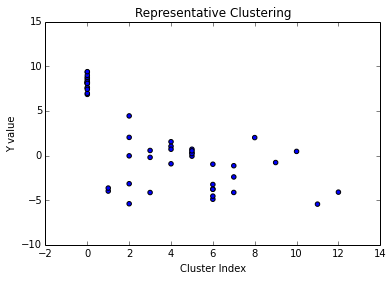

In [15]:
plt.clf()
plt.scatter(z , Y)
plt.title('Representative Clustering')
plt.xlabel('Cluster Index')
plt.ylabel('Y value')
plt.savefig('rep_clustv2.png',dpi=450)



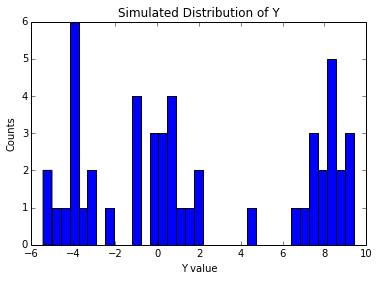

In [16]:
plt.clf()
plt.hist(Y, bins= 35)
plt.title('Simulated Distribution of Y')
plt.xlabel('Y value')
plt.ylabel('Counts')

Looks like our sampler is getting the left cluster...confused. The right-most cluster is being resolved well. Or I have a bug somewhere. Who knows?


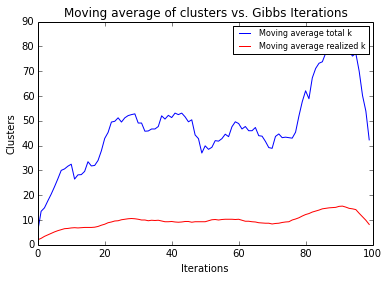

In [17]:


plt.clf()
#plt.scatter(np.arange(len(active_ks)), active_ks)

plt.plot(np.arange(len(active_ks)), movingaverage(total_ks, 10), 'b-', label='Moving average total k')
plt.plot(np.arange(len(active_ks)), movingaverage(active_ks, 10), 'r-', label='Moving average realized k')
plt.xlabel('Iterations')
plt.ylabel('Clusters')
plt.xlim((0,100))
plt.legend(prop={'size':8})
plt.title('Moving average of clusters vs. Gibbs Iterations')
plt.savefig('var_c4.png', dpi=500)


Now let's run this some more and see what happens.


In [18]:
for cur_iter in range(2400): #already ran 100 times 
    #print "Starting iter %i"%(cur_iter)
    u = np.zeros(len(Y))
    #grab u 
    for idx, val in enumerate(Y):
        cluster_label = int(z[idx])
        u[idx] = np.random.uniform(0, w[cluster_label])
    
    #min u 
    u_star = np.min(u)
    
    #find k_star and initalize components until we have enough
    beta_star = 1 - np.sum(w)
    if cur_iter > 1 and cur_iter % 50 == 0:
        print "On iteration %i\tBeta_star is %0.06f\tU-star is %0.06f\tActive ks %i\tAlpha is %0.06f\n"%(cur_iter, beta_star, u_star, active_ks[-1], total_cs[-1])
        print w
    while (beta_star >= u_star):
        _vk = np.random.beta(1, c)
        beta_k = _vk * beta_star
        
        #append beta_k to the weights
        w.append(beta_k)
            
        #append _vk to v
        v.append(_vk)
        
        #append new mu to mus 
        mus.append(np.random.normal(0, s_sqrt))
        
        #append new lambda to lambda
        new_lambd = np.random.gamma(epsilon, 1/epsilon)
        lambdas.append(new_lambd)

        
        #finally update beta_star
        beta_star = beta_star*(1 -_vk)
    
    assert len(w) == len(mus)
    assert len(w) == len(lambdas)
    
    #now we get the cluster assignments z for each observation
    for y_idx , y_val in enumerate(Y):
        z_probs = np.zeros(len(w))
        for cluster_idx, mu in enumerate(mus):
            if w[cluster_idx] > u[y_idx]:
                z_probs[cluster_idx] = norm.pdf(y_val, loc = mu, scale = lambda_to_std(lambdas[cluster_idx]))
            else:
                z_probs[cluster_idx] = 0
        #sample cluster assignments
        norm_z_probs = z_probs / np.sum(z_probs)
        z_sampler = stats.rv_discrete(name = "z_sampler", values = (np.arange(len(z_probs)), norm_z_probs))
        z_assignment = z_sampler.rvs()
        z[y_idx] = z_assignment
        #print "%i\t%0.03f\t%0.03f\t%0.03f\t%i"%(y_idx, y_val, mu_)
    
    z_ints = [int(x) for x in z] #make z ints for easier use in future 
    
    #perform necessary updates for means and lambdas for each cluster 
    new_mus = []
    new_lambdas = []
    new_z = np.zeros(len(Y))
    active_cluster = 0
    count_dict = {}
    
    for cluster_idx in range(len(w)):
        #update means
        cur_lambda = lambdas[cluster_idx]    
        eta = 0
        m = 0
        y_k = []
        for y_idx, z_val in enumerate(z_ints):
            if z_val == cluster_idx:
                m += 1
                eta += Y[y_idx]
                y_k.append(Y[y_idx])
                new_z[y_idx] = active_cluster
        
        if m == 0:
            continue
        else:
            count_dict[active_cluster] = m
            active_cluster += 1        
            _mean = (eta * cur_lambda)/(m * cur_lambda + s)
            _variance = 1 / (m * cur_lambda + s)
            new_mu = np.random.normal(_mean, np.sqrt(_variance))
            #mus[cluster_idx] = new_mu
            new_mus.append(new_mu)
            #update lambda
            d = 0
            for val in y_k:
                d += (val - new_mu) ** 2
            
            _alpha = epsilon + m/2
            _beta = epsilon + d/2
            new_lambda = np.random.gamma(_alpha, 1/_beta)
            #lambdas[cluster_idx] = new_lambda
            #print "added at %i"%(cluster_idx)
            new_lambdas.append(new_lambda)
            stds.append(lambda_to_std(new_lambda))
            
    #update the stick breaking lengths v_k 
    k = active_cluster 
    vks = []
    #print count_dict
    for cluster_idx in range(k):
        n_k = count_dict[cluster_idx]
        n_j = 0
        #print range(cluster_idx + 1, k )
        for i in range(cluster_idx+1, k):
            n_j += count_dict[i]
        vks.append(np.random.beta(1 + n_k, c + n_j))
        
    #update weights w_k
    new_w = []
    old_vks = []
    for cluster_idx in range(k):
        if cluster_idx == 0:
            new_w.append(vks[cluster_idx])    
            old_vks.append(1-vks[cluster_idx])
        else:
            #print cluster_idx
            vj = 1 
            for i in range(cluster_idx):
                #print i
                #print old_vks
                vj *= old_vks[i]
            new_w.append(vks[cluster_idx] * vj)
            old_vks.append(1-vks[cluster_idx])   
    
    #lastly, update c (alpha) and nu (Escobar & West 1995, section 6)
    #update c
    new_nu = np.random.beta(c + 1, len(Y))    
    
    pi_n_ratio = (a + k - 1) / (len(Y) * (b - np.log10(new_nu)))
    pi_1 = pi_n_ratio / (1 + pi_n_ratio)
    pi_2 = 1 - pi_1
    #new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    #new_c = np.random.gamma(a+k, b - np.log10(new_nu))
    #new_c = ((c**k )* gamma(c) * np.random.gamma(0.1,10)) / (gamma(c + len(Y)))      
    
    #store results
    active_ks.append(k)
    total_ks.append(len(w))
    total_cs.append(new_c)
    
    #end of gibbs cycle, update all the variables for next round
    mus = new_mus
    lambdas = new_lambdas
    z = new_z 
    c = new_c
    nu = new_nu
    v = vks 
    w = new_w

On iteration 50	Beta_star is 0.043600	U-star is 0.000417	Active ks 14	Alpha is 17.434319

[0.3614879836200339, 0.05194793698191956, 0.08246089286311464, 0.20525331076393166, 0.008643307166680905, 0.03834284314103191, 0.030463169916479908, 0.0015437306541452739, 0.1013207599584383, 0.004313326720361994, 0.03498110557313655, 0.013381811855715511, 0.010697864875247279, 0.011562050255046646]
On iteration 100	Beta_star is 0.192436	U-star is 0.000477	Active ks 11	Alpha is 7.634897

[0.33107117725958124, 0.08882575469537378, 0.08321442620610082, 0.03640758576936084, 0.019182341064948347, 0.07542541440666893, 0.04088899038313724, 0.012166604429914699, 0.019133541433833383, 0.04619895023191165, 0.05504953588276193]
On iteration 150	Beta_star is 0.066215	U-star is 0.001342	Active ks 9	Alpha is 9.484994

[0.2597128849201762, 0.20133356075347292, 0.15490381075710105, 0.1696318675514633, 0.06983093784661341, 0.021530412813650705, 0.014013916920033244, 0.028626556041653328, 0.014201105053031545]
On 

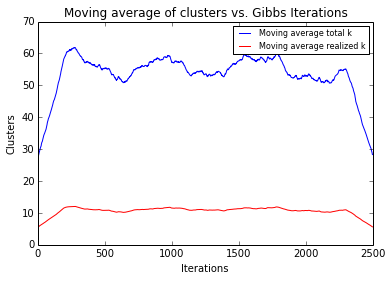

In [21]:

plt.clf()
#plt.scatter(np.arange(len(active_ks)), active_ks)

plt.plot(np.arange(len(active_ks)), movingaverage(total_ks, 400), 'b-', label='Moving average total k')
plt.plot(np.arange(len(active_ks)), movingaverage(active_ks, 400), 'r-', label='Moving average realized k')
plt.xlabel('Iterations')
plt.ylabel('Clusters')
plt.xlim((0,2500))
plt.legend(prop={'size':8})
plt.title('Moving average of clusters vs. Gibbs Iterations')
plt.savefig('var_6.png', dpi=500)


In [22]:
print np.mean(active_ks)
print np.mean(total_ks)

11.0652
55.5164


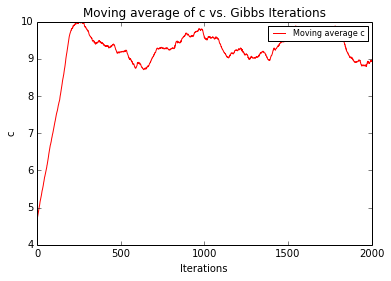

In [23]:

plt.clf()
#plt.scatter(np.arange(len(active_ks)), active_ks)

plt.plot(np.arange(len(active_ks)), movingaverage(total_cs, 400), 'r-', label='Moving average c')
plt.xlabel('Iterations')
plt.ylabel('c')
plt.xlim((0,2000))
plt.legend(prop={'size':8})
plt.title('Moving average of c vs. Gibbs Iterations')
plt.savefig('var_6.png', dpi=500)


Looks like our algorithm is dramatically over_estimating the number of active clusters. The c values seem to be...off. 
What if we fix $c$? (Fix $c = 1$) 

I think there is something wrong with my $c$ updates...


In [24]:
epsilon = 0.5
s = 0.1
s_inv = 1/s
s_sqrt = np.sqrt(s_inv)
#s_sqrt = s_inv
a = 0.1
b = 0.1 
c = 1
nu = np.random.beta(c+1, len(Y))

#cycle 1
#initalize first weights
w = []
w.append(np.random.beta(1, c))

v = []
v.append(w[0])
#initalize first mu
mus = []
mus.append(np.random.normal(0, s_sqrt))

#initalize first lambda
lambdas = []
lambdas.append(np.random.gamma(epsilon,epsilon))
stds = []
stds.append(lambda_to_std(lambdas[0]))
z = np.zeros(len(Y)) #cluster assignments
u = np.zeros(len(Y))
active_ks = []
total_ks = []
total_cs = []

for cur_iter in range(2500):
    #print "Starting iter %i"%(cur_iter)
    u = np.zeros(len(Y))
    #grab u 
    for idx, val in enumerate(Y):
        cluster_label = int(z[idx])
        u[idx] = np.random.uniform(0, w[cluster_label])
    
    #min u 
    u_star = np.min(u)
    
    #find k_star and initalize components until we have enough
    beta_star = 1 - np.sum(w)
    if cur_iter > 1 and cur_iter % 50 == 0:
        print "On iteration %i\tBeta_star is %0.06f\tU-star is %0.06f\tActive ks %i\tAlpha is %0.06f\n"%(cur_iter, beta_star, u_star, active_ks[-1], total_cs[-1])
        print w
    while (beta_star >= u_star):
        _vk = np.random.beta(1, c)
        beta_k = _vk * beta_star
        
        #append beta_k to the weights
        w.append(beta_k)
            
        #append _vk to v
        v.append(_vk)
        
        #append new mu to mus 
        mus.append(np.random.normal(0, s_sqrt))
        
        #append new lambda to lambda
        new_lambd = np.random.gamma(epsilon, 1/epsilon)
        lambdas.append(new_lambd)

        
        #finally update beta_star
        beta_star = beta_star*(1 -_vk)
    
    assert len(w) == len(mus)
    assert len(w) == len(lambdas)
    
    #now we get the cluster assignments z for each observation
    for y_idx , y_val in enumerate(Y):
        z_probs = np.zeros(len(w))
        for cluster_idx, mu in enumerate(mus):
            if w[cluster_idx] > u[y_idx]:
                z_probs[cluster_idx] = norm.pdf(y_val, loc = mu, scale = lambda_to_std(lambdas[cluster_idx]))
            else:
                z_probs[cluster_idx] = 0
        #sample cluster assignments
        norm_z_probs = z_probs / np.sum(z_probs)
        z_sampler = stats.rv_discrete(name = "z_sampler", values = (np.arange(len(z_probs)), norm_z_probs))
        z_assignment = z_sampler.rvs()
        z[y_idx] = z_assignment
        #print "%i\t%0.03f\t%0.03f\t%0.03f\t%i"%(y_idx, y_val, mu_)
    
    z_ints = [int(x) for x in z] #make z ints for easier use in future 
    
    #perform necessary updates for means and lambdas for each cluster 
    new_mus = []
    new_lambdas = []
    new_z = np.zeros(len(Y))
    active_cluster = 0
    count_dict = {}
    
    for cluster_idx in range(len(w)):
        #update means
        cur_lambda = lambdas[cluster_idx]    
        eta = 0
        m = 0
        y_k = []
        for y_idx, z_val in enumerate(z_ints):
            if z_val == cluster_idx:
                m += 1
                eta += Y[y_idx]
                y_k.append(Y[y_idx])
                new_z[y_idx] = active_cluster
        
        if m == 0:
            continue
        else:
            count_dict[active_cluster] = m
            active_cluster += 1        
            _mean = (eta * cur_lambda)/(m * cur_lambda + s)
            _variance = 1 / (m * cur_lambda + s)
            new_mu = np.random.normal(_mean, np.sqrt(_variance))
            #mus[cluster_idx] = new_mu
            new_mus.append(new_mu)
            #update lambda
            d = 0
            for val in y_k:
                d += (val - new_mu) ** 2
            
            _alpha = epsilon + m/2
            _beta = epsilon + d/2
            new_lambda = np.random.gamma(_alpha, 1/_beta)
            #lambdas[cluster_idx] = new_lambda
            #print "added at %i"%(cluster_idx)
            new_lambdas.append(new_lambda)
            stds.append(lambda_to_std(new_lambda))
            
    #update the stick breaking lengths v_k 
    k = active_cluster 
    vks = []
    #print count_dict
    for cluster_idx in range(k):
        n_k = count_dict[cluster_idx]
        n_j = 0
        #print range(cluster_idx + 1, k )
        for i in range(cluster_idx+1, k):
            n_j += count_dict[i]
        vks.append(np.random.beta(1 + n_k, c + n_j))
        
    #update weights w_k
    new_w = []
    old_vks = []
    for cluster_idx in range(k):
        if cluster_idx == 0:
            new_w.append(vks[cluster_idx])    
            old_vks.append(1-vks[cluster_idx])
        else:
            #print cluster_idx
            vj = 1 
            for i in range(cluster_idx):
                #print i
                #print old_vks
                vj *= old_vks[i]
            new_w.append(vks[cluster_idx] * vj)
            old_vks.append(1-vks[cluster_idx])   
    
    #lastly, update c (alpha) and nu (Escobar & West 1995, section 6)
    #update c
    new_nu = np.random.beta(c + 1, len(Y))    
    
    pi_n_ratio = (a + k - 1) / (len(Y) * (b - np.log10(new_nu)))
    pi_1 = pi_n_ratio / (1 + pi_n_ratio)
    pi_2 = 1 - pi_1
    #new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    #new_c = np.random.gamma(a+k, b - np.log10(new_nu))
    #new_c = ((c**k )* gamma(c) * np.random.gamma(0.1,10)) / (gamma(c + len(Y)))      
    
    #store results
    active_ks.append(k)
    total_ks.append(len(w))
    total_cs.append(new_c)
    
    #end of gibbs cycle, update all the variables for next round
    mus = new_mus
    lambdas = new_lambdas
    z = new_z 
    c = 1 #fix c
    nu = new_nu
    v = vks 
    w = new_w


On iteration 50	Beta_star is 0.018051	U-star is 0.004614	Active ks 5	Alpha is 4.563308

[0.25883372174933594, 0.2502570805984022, 0.16778696066957494, 0.28545250060363536, 0.019618934636001575]
On iteration 100	Beta_star is 0.016298	U-star is 0.005445	Active ks 6	Alpha is 19.251681

[0.323200128459084, 0.0888885455485855, 0.37788291659799766, 0.16066745381972783, 0.019134367478306828, 0.013928385157903064]
On iteration 150	Beta_star is 0.005593	U-star is 0.001901	Active ks 5	Alpha is 2.755946

[0.30565358202646853, 0.3537989144933992, 0.25500208478782993, 0.03151680422538613, 0.04843574213858807]
On iteration 200	Beta_star is 0.001922	U-star is 0.003530	Active ks 4	Alpha is 2.996882

[0.33046143836844166, 0.357154369383644, 0.2863851197153336, 0.024077383343893463]
On iteration 250	Beta_star is 0.018556	U-star is 0.000596	Active ks 4	Alpha is 3.970955

[0.3334721105033861, 0.4303807017693731, 0.20950878513170312, 0.008082756894214498]
On iteration 300	Beta_star is 0.007546	U-star is 0.

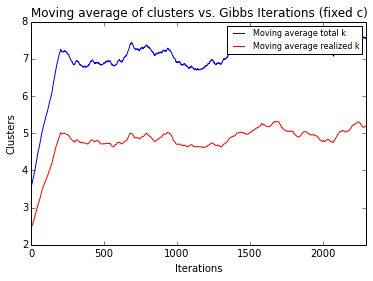

In [26]:

plt.clf()
#plt.scatter(np.arange(len(active_ks)), active_ks)

plt.plot(np.arange(len(active_ks)), movingaverage(total_ks, 400), 'b-', label='Moving average total k')
plt.plot(np.arange(len(active_ks)), movingaverage(active_ks, 400), 'r-', label='Moving average realized k')
plt.xlabel('Iterations')
plt.ylabel('Clusters')
plt.xlim((0,2300))
plt.legend(prop={'size':8})
plt.title('Moving average of clusters vs. Gibbs Iterations (fixed c)')
plt.savefig('var_7.png', dpi=500)


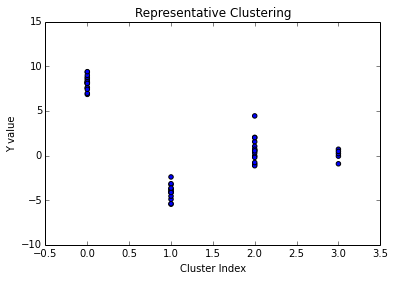

In [27]:
plt.clf()
plt.scatter(z , Y)
plt.title('Representative Clustering')
plt.xlabel('Cluster Index')
plt.ylabel('Y value')
plt.savefig('rep_clustv7.png',dpi=450)



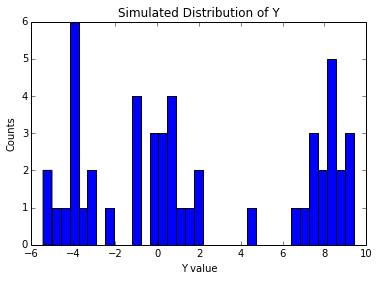

In [28]:
plt.clf()
plt.hist(Y, bins= 35)
plt.title('Simulated Distribution of Y')
plt.xlabel('Y value')
plt.ylabel('Counts')

Let's visualize how $u^*$ changes with sampling iterations. 


In [29]:
epsilon = 0.5
s = 0.1
s_inv = 1/s
s_sqrt = np.sqrt(s_inv)
#s_sqrt = s_inv
a = 0.1
b = 0.1 
c = 1
nu = np.random.beta(c+1, len(Y))

#cycle 1
#initalize first weights
w = []
w.append(np.random.beta(1, c))

v = []
v.append(w[0])
#initalize first mu
mus = []
mus.append(np.random.normal(0, s_sqrt))

#initalize first lambda
lambdas = []
lambdas.append(np.random.gamma(epsilon,epsilon))
stds = []
stds.append(lambda_to_std(lambdas[0]))
z = np.zeros(len(Y)) #cluster assignments
u = np.zeros(len(Y))
active_ks = []
total_ks = []
total_cs = []
total_ustar = []
for cur_iter in range(2500):
    #print "Starting iter %i"%(cur_iter)
    u = np.zeros(len(Y))
    #grab u 
    for idx, val in enumerate(Y):
        cluster_label = int(z[idx])
        u[idx] = np.random.uniform(0, w[cluster_label])
    
    #min u 
    u_star = np.min(u)
    total_ustar.append(u_star)
    
    #find k_star and initalize components until we have enough
    beta_star = 1 - np.sum(w)
    if cur_iter > 1 and cur_iter % 50 == 0:
        print "On iteration %i\tBeta_star is %0.06f\tU-star is %0.06f\tActive ks %i\tAlpha is %0.06f\n"%(cur_iter, beta_star, u_star, active_ks[-1], total_cs[-1])
        print w
    while (beta_star >= u_star):
        _vk = np.random.beta(1, c)
        beta_k = _vk * beta_star
        
        #append beta_k to the weights
        w.append(beta_k)
            
        #append _vk to v
        v.append(_vk)
        
        #append new mu to mus 
        mus.append(np.random.normal(0, s_sqrt))
        
        #append new lambda to lambda
        new_lambd = np.random.gamma(epsilon, 1/epsilon)
        lambdas.append(new_lambd)

        
        #finally update beta_star
        beta_star = beta_star*(1 -_vk)
    
    assert len(w) == len(mus)
    assert len(w) == len(lambdas)
    
    #now we get the cluster assignments z for each observation
    for y_idx , y_val in enumerate(Y):
        z_probs = np.zeros(len(w))
        for cluster_idx, mu in enumerate(mus):
            if w[cluster_idx] > u[y_idx]:
                z_probs[cluster_idx] = norm.pdf(y_val, loc = mu, scale = lambda_to_std(lambdas[cluster_idx]))
            else:
                z_probs[cluster_idx] = 0
        #sample cluster assignments
        norm_z_probs = z_probs / np.sum(z_probs)
        z_sampler = stats.rv_discrete(name = "z_sampler", values = (np.arange(len(z_probs)), norm_z_probs))
        z_assignment = z_sampler.rvs()
        z[y_idx] = z_assignment
        #print "%i\t%0.03f\t%0.03f\t%0.03f\t%i"%(y_idx, y_val, mu_)
    
    z_ints = [int(x) for x in z] #make z ints for easier use in future 
    
    #perform necessary updates for means and lambdas for each cluster 
    new_mus = []
    new_lambdas = []
    new_z = np.zeros(len(Y))
    active_cluster = 0
    count_dict = {}
    
    for cluster_idx in range(len(w)):
        #update means
        cur_lambda = lambdas[cluster_idx]    
        eta = 0
        m = 0
        y_k = []
        for y_idx, z_val in enumerate(z_ints):
            if z_val == cluster_idx:
                m += 1
                eta += Y[y_idx]
                y_k.append(Y[y_idx])
                new_z[y_idx] = active_cluster
        
        if m == 0:
            continue
        else:
            count_dict[active_cluster] = m
            active_cluster += 1        
            _mean = (eta * cur_lambda)/(m * cur_lambda + s)
            _variance = 1 / (m * cur_lambda + s)
            new_mu = np.random.normal(_mean, np.sqrt(_variance))
            #mus[cluster_idx] = new_mu
            new_mus.append(new_mu)
            #update lambda
            d = 0
            for val in y_k:
                d += (val - new_mu) ** 2
            
            _alpha = epsilon + m/2
            _beta = epsilon + d/2
            new_lambda = np.random.gamma(_alpha, 1/_beta)
            #lambdas[cluster_idx] = new_lambda
            #print "added at %i"%(cluster_idx)
            new_lambdas.append(new_lambda)
            stds.append(lambda_to_std(new_lambda))
            
    #update the stick breaking lengths v_k 
    k = active_cluster 
    vks = []
    #print count_dict
    for cluster_idx in range(k):
        n_k = count_dict[cluster_idx]
        n_j = 0
        #print range(cluster_idx + 1, k )
        for i in range(cluster_idx+1, k):
            n_j += count_dict[i]
        vks.append(np.random.beta(1 + n_k, c + n_j))
        
    #update weights w_k
    new_w = []
    old_vks = []
    for cluster_idx in range(k):
        if cluster_idx == 0:
            new_w.append(vks[cluster_idx])    
            old_vks.append(1-vks[cluster_idx])
        else:
            #print cluster_idx
            vj = 1 
            for i in range(cluster_idx):
                #print i
                #print old_vks
                vj *= old_vks[i]
            new_w.append(vks[cluster_idx] * vj)
            old_vks.append(1-vks[cluster_idx])   
    
    #lastly, update c (alpha) and nu (Escobar & West 1995, section 6)
    #update c
    new_nu = np.random.beta(c + 1, len(Y))    
    
    pi_n_ratio = (a + k - 1) / (len(Y) * (b - np.log10(new_nu)))
    pi_1 = pi_n_ratio / (1 + pi_n_ratio)
    pi_2 = 1 - pi_1
    #new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    new_c = pi_1 * np.random.gamma(a+k, b - np.log10(new_nu)) + pi_2 * np.random.gamma(a+k-1, b-np.log10(new_nu))
    #new_c = np.random.gamma(a+k, b - np.log10(new_nu))
    #new_c = ((c**k )* gamma(c) * np.random.gamma(0.1,10)) / (gamma(c + len(Y)))      
    
    #store results
    active_ks.append(k)
    total_ks.append(len(w))
    total_cs.append(new_c)
    
    #end of gibbs cycle, update all the variables for next round
    mus = new_mus
    lambdas = new_lambdas
    z = new_z 
    c = 1 #fix c
    nu = new_nu
    v = vks 
    w = new_w


On iteration 50	Beta_star is 0.006844	U-star is 0.002858	Active ks 6	Alpha is 7.482053

[0.30440915767300336, 0.26810223476911005, 0.1591202352032478, 0.22159695794676318, 0.032692482335740444, 0.007235299462911448]
On iteration 100	Beta_star is 0.017980	U-star is 0.001259	Active ks 5	Alpha is 5.500004

[0.2576777175011397, 0.2641170021297535, 0.3759452403304005, 0.036392521997813995, 0.04788706708533892]
On iteration 150	Beta_star is 0.000973	U-star is 0.000399	Active ks 6	Alpha is 11.631646

[0.3688044751435461, 0.09759729925408754, 0.35121790790574386, 0.10767111057807105, 0.07074615265218341, 0.002989910652621198]
On iteration 200	Beta_star is 0.029609	U-star is 0.003971	Active ks 3	Alpha is 7.245786

[0.3899052830609952, 0.23935076905212793, 0.34113536772244474]
On iteration 250	Beta_star is 0.001636	U-star is 0.010885	Active ks 3	Alpha is 9.440252

[0.4009753501049698, 0.33054554406686004, 0.26684289423381247]
On iteration 300	Beta_star is 0.004825	U-star is 0.002418	Active ks 5	

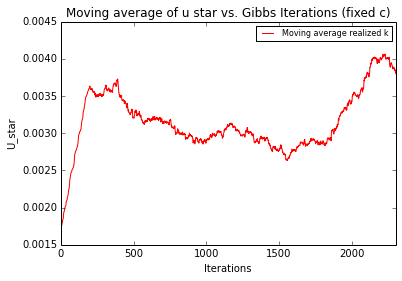

In [30]:
plt.plot(np.arange(len(active_ks)), movingaverage(total_ustar, 400), 'r-', label='Moving average realized k')
plt.xlabel('Iterations')
plt.ylabel('U_star')
plt.xlim((0,2300))
plt.legend(prop={'size':8})
plt.title('Moving average of u star vs. Gibbs Iterations (fixed c)')
plt.savefig('var_8.png', dpi=500)
